In [1]:
import numpy as np
from scipy import stats,fftpack
from tensorflow.keras.utils import to_categorical
from stochastic import diffusion, continuous
from scipy.optimize import curve_fit
import scipy.io

In [2]:
batchsize = 32
T = 100 # this provides another layer of stochasticity to make the network more robust
steps = 1000 # number of steps to generate
initializer = 'he_normal'
f = 32
sigma = 0.1

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
def Sub_mixing(x0, n, dt, scales, out=None):
    x0 = np.asarray(x0)
    # generate a sample of n numbers from a normal distribution.
    r = stats.norm.rvs(size=x0.shape + (n,), scale=np.sqrt(dt))
    r = r*scales
    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)
    # Compute Brownian motion by forming the cumulative sum of random samples. 
    np.cumsum(r, axis=-1, out=out)
    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out

def Mixing(N=1000,T=50,deltas = [1], rate = .1):
    x = np.empty((2,N+1))
    x[:,0] = 0.0

    jumps = np.random.poisson(lam = rate*T)
    jumptimes = np.random.rand(jumps)*N
    jumptimes.sort()
    dc = np.empty(jumps+1)
    dc[0] = np.random.choice(deltas)
    for i, element in enumerate(dc[:-1]):
        temp = deltas[:]  # fastest way to copy
        if len(temp) > 1:
            temp.remove(element)
        dc[i+1] = np.random.choice(temp)

    scales = np.ones(N)*dc[0]

    prev = 0
    succ = None

    for index, jump in enumerate(jumptimes):
        if prev <= N:
            scales[prev:int(jump // 1 + 1)] = dc[index]
            if jump + 1 <= N:
                scales[int(jump // 1 + 1)] = dc[index] * (jump % 1) + dc[index+1] * (1 - jump % 1)
        prev = int(jump // 1 + 2)
    if prev <= N:
        scales[prev:] = dc[-1]

    Sub_mixing(x[:,0], N, T/N, scales, out=x[:,1:])

    out1 = x[0]
    out2 = x[1]

    return out1,out2, jumps

In [5]:
'''
Generator functions for neural network training per Keras specifications
input for all functions is as follows:
    
input: 
   - batch size
   - steps: total number of steps in trajectory (list) 
   - T: final time (list)
   - sigma: Standard deviation of localization noise (std of a fixed cell/bead)
'''

# Randomly generate trajectories of different diffusion models for training of the 
# classification network
    
def generate(batchsize=32,steps=steps,T=30,sigma=0.1):
    while True:
        # randomly choose a set of trajectory-length and final-time. This is intended
        # to increase variability in simuation conditions.
        T1 = T #np.random.choice(T,size=1).item()
        out = np.zeros([batchsize,steps-1,1])
        label = np.zeros([batchsize,1])
#         weight = np.zeros(batchsize)
        for i in range(batchsize):
            # randomly select diffusion model to simulate for this iteration
            constants = 2
            dcs = [1,10]
#           dcs = np.random.uniform(low = 0, high = 20, size = constants)
            x,y,jumps = Mixing(N=steps,T=T1,deltas= dcs, rate = .1) 
            label[i,0] = jumps + 1 #TODO 
#             weight[i] =  1/stats.poisson.pmf(jumps, mu = .1*T)
            noise = np.sqrt(sigma)*np.random.randn(1,steps)
            x1 = np.reshape(x,[1,len(x)])
            x1 = x1-np.mean(x1)
            x_n = x1[0,:steps]+noise
            dx = np.diff(x_n)
            out[i,:,0] = dx
       
#         label = to_categorical(label)

        yield out,label,[None]


In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input,GlobalMaxPooling1D,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

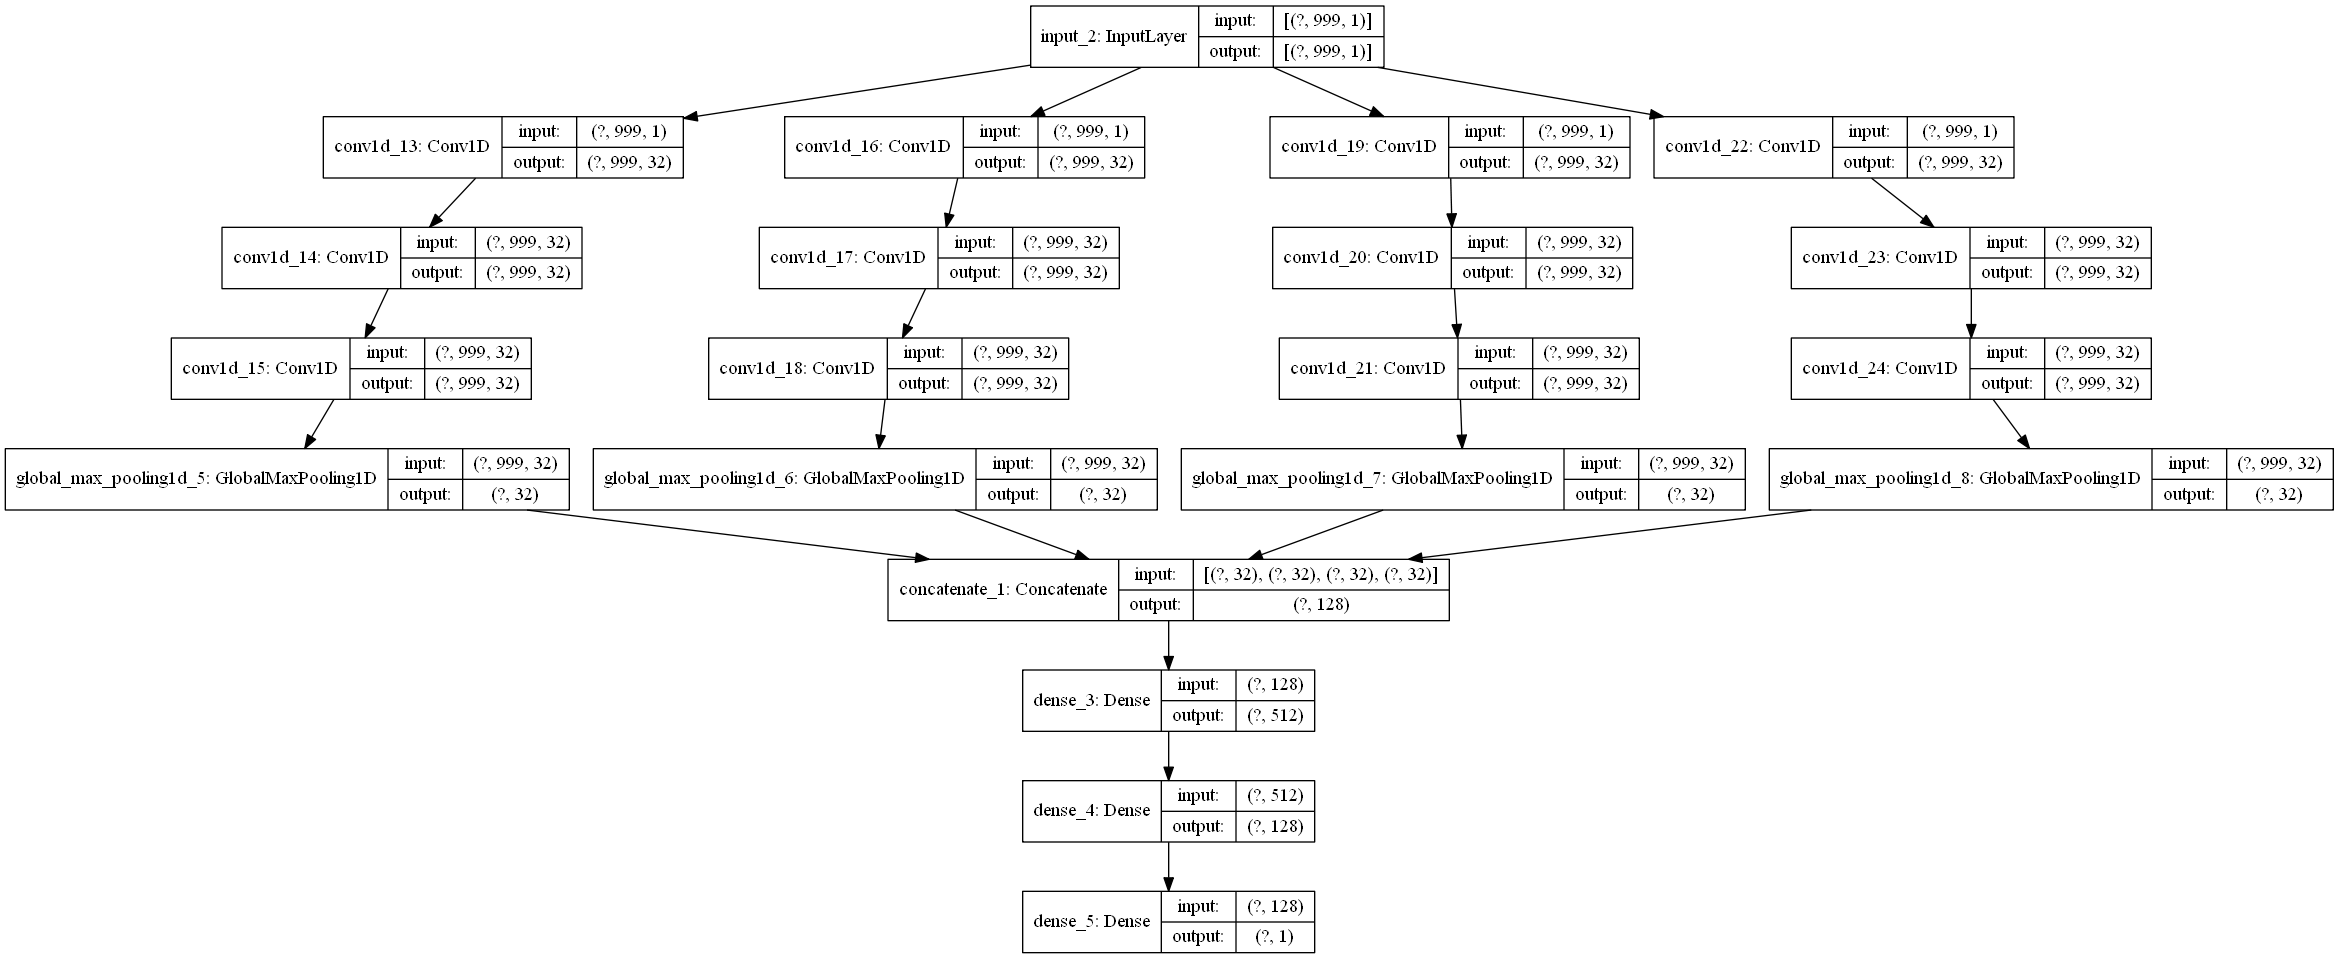

In [11]:
inputs = Input((steps-1,1))

x1 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x1 = Conv1D(f,4,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = Conv1D(f,4,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = GlobalMaxPooling1D()(x1)


x2 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x2 = Conv1D(f,2,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = Conv1D(f,2,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = GlobalMaxPooling1D()(x2)


x3 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x3 = Conv1D(f,3,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = Conv1D(f,3,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = GlobalMaxPooling1D()(x3)


x4 = Conv1D(f,10,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x4 = Conv1D(f,10,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = Conv1D(f,10,dilation_rate=8,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = GlobalMaxPooling1D()(x4)


x5 = Conv1D(f,20,padding='same',activation='relu',kernel_initializer=initializer)(inputs)
x5 = GlobalMaxPooling1D()(x5)


con = concatenate([x1,x2,x3,x4])
dense = Dense(512,activation='relu')(con)
dense = Dense(128,activation='relu')(dense)
dense2 = Dense(1,activation='relu')(dense)
model = Model(inputs=inputs, outputs=dense2)

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='MAPE',metrics=['MAPE'])
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=50,
        verbose=1,
        min_delta=1e-4
    ),
#     ReduceLROnPlateau(
#         monitor='MAPE',
#         factor=0.1,
#         patience=4,
#         verbose=1,
#         min_lr=1e-9
#     ),
    ModelCheckpoint(
        filepath='new_class_model.h5',
        monitor='MAPE',
        save_best_only=True,
        mode='min',
        save_weights_only=False
    )
]

In [13]:
gen = generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma)

history = model.fit(gen,
        steps_per_epoch=5,
        epochs=4000,
        callbacks=callbacks,
        validation_data=generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma),
        validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/4000
5/5 [==============================] - 3s 556ms/step - loss: 97.8779 - MAPE: 97.8779 - val_loss: 94.7342 - val_MAPE: 94.7342
Epoch 2/4000
5/5 [==============================] - 1s 109ms/step - loss: 90.7191 - MAPE: 90.7191 - val_loss: 82.0270 - val_MAPE: 82.0270
Epoch 3/4000
5/5 [==============================] - 1s 106ms/step - loss: 78.7289 - MAPE: 78.7289 - val_loss: 69.4125 - val_MAPE: 69.4125
Epoch 4/4000
5/5 [==============================] - 1s 108ms/step - loss: 67.3716 - MAPE: 67.3716 - val_loss: 59.8316 - val_MAPE: 59.8316
Epoch 5/4000
5/5 [==============================] - 1s 108ms/step - loss: 53.3311 - MAPE: 53.3311 - val_loss: 49.5858 - val_MAPE: 49.5858
Epoch 6/4000
5/5 [==============================] - 1s 107ms/step - loss: 43.6453 - MAPE: 43.6453 - val_loss: 38.5530 - val_MAPE: 38.5530
Epoch 7/4000
5/5 [==============================] - 1s 108ms/step - loss: 33.7296 - MAPE: 33.7296 - val_loss: 30.8305 - val_MAPE: 30

In [14]:
model = keras.models.load_model('new_class_model.h5')
model.evaluate(gen, steps = 50)

50/50 [==============================] - 1s 29ms/step - loss: 27.3789 - MAPE: 27.3789


[27.378898315429687, 27.378899]

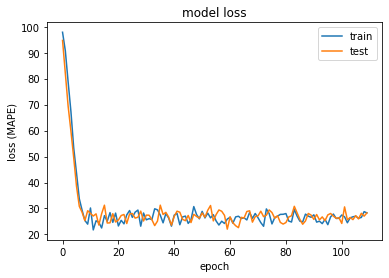

In [22]:
from matplotlib import pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (MAPE)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('number_of_switches_learning.pdf')

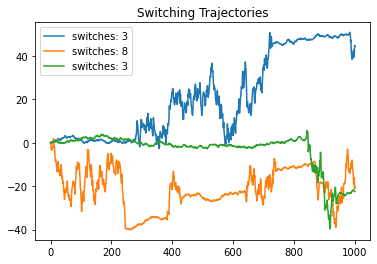

In [16]:
for i in range(3):
    jumplist = []
    test, _ ,jumps = Mixing(deltas = [1,10])
    test = np.squeeze(test)
    plt.plot(test, label = "switches: " + str(jumps))
plt.title('Switching Trajectories')
plt.legend(loc='upper left')
plt.savefig('switchintraj_number of jumps.pdf')

In [17]:
gen = generate(batchsize=1000,steps=steps,T=T,sigma=sigma)
# next(gen)

In [18]:
test, labels, _ = next(gen)

predictions = model.predict(test)
predictions

array([[10.888284 ],
       [12.3485   ],
       [10.17497  ],
       [10.684868 ],
       [ 9.880791 ],
       [11.244014 ],
       [12.342821 ],
       [10.617764 ],
       [10.564775 ],
       [10.3948145],
       [11.657438 ],
       [11.109003 ],
       [ 9.781557 ],
       [ 9.60964  ],
       [11.247095 ],
       [11.650663 ],
       [ 9.864616 ],
       [12.47097  ],
       [10.170075 ],
       [10.969414 ],
       [10.437953 ],
       [ 8.33677  ],
       [10.657386 ],
       [ 9.740331 ],
       [10.919482 ],
       [11.331291 ],
       [11.781823 ],
       [10.619937 ],
       [10.718532 ],
       [ 7.466945 ],
       [10.5469475],
       [10.632501 ],
       [10.673025 ],
       [10.909101 ],
       [10.52538  ],
       [11.350727 ],
       [10.857357 ],
       [10.8046665],
       [10.211611 ],
       [10.781383 ],
       [10.196071 ],
       [10.740373 ],
       [ 9.156785 ],
       [11.304579 ],
       [11.326883 ],
       [10.789207 ],
       [11.043973 ],
       [10.65

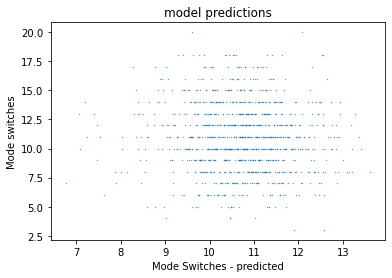

In [20]:
plt.scatter(
    y = labels,
    x = predictions,
    s = .1
)
# plt.legend(loc = 'upper right')
plt.title('model predictions')
plt.ylabel('Mode switches')
plt.xlabel('Mode Switches - predicted')
plt.savefig('numberofmodeswitches.pdf')

In [ ]:
np.shape(labels)

In [ ]:
model.evaluate(gen, steps = 50)

In [ ]:
model.evaluate(gen, steps = 50)

In [ ]:
plt.hist(predictions)